# Mildew cucumber models
Below are the different models used to calculate the risk of mildew appearance. 

First we will show the results we have with the FieldClimate site, Pessl chose to use the model "Blight by Phythopthora infestans" also used for potato mildew.

Afterwards we will show the results with our implementation of the models:

- Homemade model based on Pessl results
- NegFry : model also used for potato
- A model from a study in North and South Carolina, USA

We collected data with the different environmental station we installed.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Options: 'braig', 'guillod', 'hammerli', 'johner', 'moser'
stations = ['braig',
            # 'guillod',
            'hammerli',
            'johner',
            'moser']

# Read csv
dfs = [pd.read_csv("in/data_braig.csv"),
       #  pd.read_csv("in/data_guillod.csv"),
       pd.read_csv("in/data_hammerli.csv"),
       pd.read_csv("in/data_johner.csv"),
       pd.read_csv("in/data_moser.csv")]

plt.rcParams['figure.figsize'] = [20, 10]

for df in dfs:
    # Sort data by date
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by=["date"], ignore_index=True, inplace=True)
    df = df.dropna()



## Autoregressive Integrated Moving Average Model (ARIMA)
This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def forcast_ts(data, tt_ratio, order=(5,1,0), predict_cascade=False, threshold=0):
    X = data.values
    size = int(len(X) * tt_ratio)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]

        predictions.append(yhat)
        obs = test[t]
        if predict_cascade:
            history.append(yhat)
        else: 
            history.append(obs)
        print('progress:%',round(100*(t/len(test))),'\t predicted=%f, expected=%f' % (yhat, obs), end="\r")
    error = mean_squared_error(test, predictions)
    print('\n Test MSE: %.3f' % error)

    plt.rcParams["figure.figsize"] = (15,5)
    preds = np.append(train, predictions)
    if threshold > 0:
        predictions = [predictions[i] > threshold for i in range(len(predictions))]
    plt.plot(list(predictions), color='green', linewidth=2, label="Predicted Data")
    plt.plot(list(data[-len(predictions):]), color='blue', linewidth=1, label="Original Data")
    # plt.plot(list(preds), color='green', linewidth=2, label="Predicted Data")
    # plt.plot(list(data), color='blue', linewidth=1, label="Original Data")
    # plt.axvline(x=int(len(data)*tt_ratio)-1, linewidth=2, color='red')
    plt.legend()
    plt.show()

## Calculate pdq

Autocorrelation (ACF) plot can be used to find if time series is stationarity. It also can be helpful to find the order of moving average part in ARIMA model. Partial autocorrelation (PACF) plot is useful to identify the order of autoregressive part in ARIMA model. 

Augmented Dickey–Fuller unit test examines if the time series is non-stationary. The null hypothesis is that the series is non-stationary, hence if the p-value is small, it implies the time series is NOT non-stationary.

- p: the number of lag observations in the model; also known as the lag order.
- d: the number of times that the raw observations are differenced; also known as the degree of differencing.
- q: the size of the moving average window; also known as the order of the moving average.

p and q can be defined with the results of the Dickey-Fuller unit test.

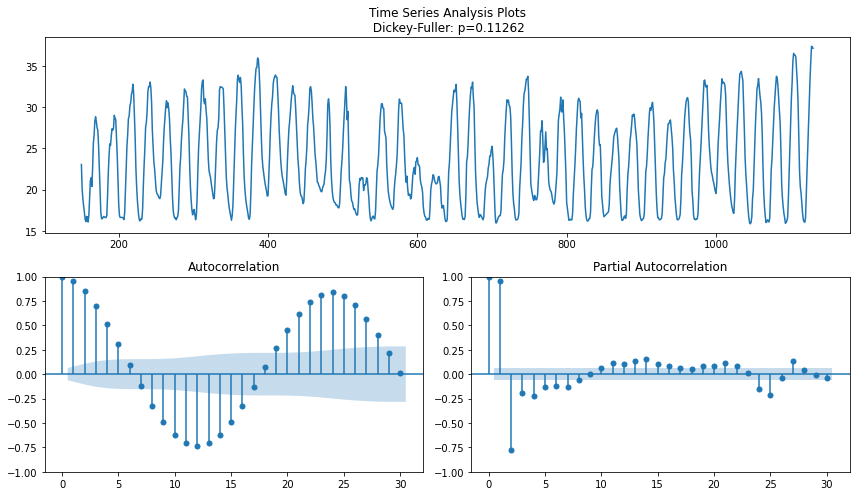

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
def acf_pacf_dickey_fuller_plot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    
acf_pacf_dickey_fuller_plot(dfs[0]["atmos14_temperature"][150:].dropna())

Dickey-Fuller test p-value is significant which means the series now is more likely to be stationary. We can see that the lag point is at the 24 at x both times. It normally means that we have a (24, d, 0) or (0, d, 24) models. The d value, the value of differencing is low in general. We decided to try few of these models and see which give the best results.

The best result was by combining both supposition to have a (24, d, 24) with d at 1 or 2.

progress:% 99 	 predicted=16.034481, expected=14.233330
 Test MSE: 2.546


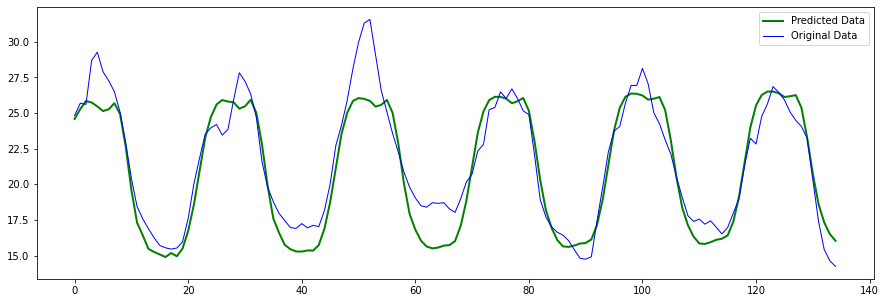

In [19]:
n_samples = 24*28 # 4 weeks

data = df['atmos14_temperature'][:n_samples]
data.shape
tt_ratio = 0.80 # Train to Test ratio
forcast_ts(data, tt_ratio, order=(24,2,24), predict_cascade=True)

progress:% 99 	 predicted=0.948256, expected=0.974499
 Test MSE: 0.010


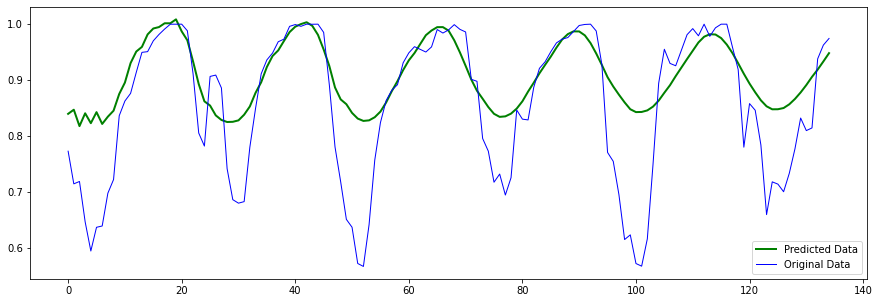

In [25]:
n_samples = 24*28 # 4 weeks

data = df['atmos14_moisture'][:n_samples]
data.shape
tt_ratio = 0.80 # Train to Test ratio
forcast_ts(data, tt_ratio, order=(24,1,24), predict_cascade=True)